## Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer 
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
import matplotlib.pyplot as plt 
import warnings

## Display Settings

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output="pandas")

In [5]:
warnings.filterwarnings("ignore")

## Read the data

In [6]:
train=pd.read_csv("data/train.csv")
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-21,Delhi,Cochin,07:05:00,21:00:00,835,1.0,No Info,13062
1,Vistara,2019-06-03,Chennai,Kolkata,07:05:00,09:20:00,135,0.0,No Info,3687
2,Indigo,2019-06-03,Delhi,Cochin,11:25:00,01:30:00,845,1.0,No Info,5883
3,Jet Airways,2019-06-06,Delhi,Cochin,20:55:00,04:25:00,450,1.0,In-flight meal not included,10262
4,Jet Airways,2019-06-27,Delhi,Cochin,18:20:00,19:00:00,1480,2.0,No Info,14300


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train=train.drop(columns="price")
y_train=train.price.copy()

## Transformation Operations

### Airline

In [9]:
X_train.airline

0      Multiple Carriers
1                Vistara
2                 Indigo
3            Jet Airways
4            Jet Airways
             ...        
635               Indigo
636          Jet Airways
637               Indigo
638            Air India
639               Indigo
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='Other',n_categories=2)),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

air_transformer.fit_transform(X_train.loc[:,['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,1.0,0.0,0.0,0.0,0.0


In [11]:
type(X_train.iloc[:,0])

pandas.core.series.Series

In [12]:
X_train.iloc[:,[0]]

,airline
0,Multiple Carriers
1,Vistara
2,Indigo
3,Jet Airways
4,Jet Airways
...,...
635,Indigo
636,Jet Airways
637,Indigo
638,Air India


In [13]:
type(X_train.iloc[:,[0]])

pandas.core.frame.DataFrame

In [14]:
type(X_train.loc[:,['airline']])

pandas.core.frame.DataFrame

### Date of journey

In [15]:
X_train.date_of_journey

0      2019-03-21
1      2019-06-03
2      2019-06-03
3      2019-06-06
4      2019-06-27
          ...    
635    2019-05-21
636    2019-05-18
637    2019-06-06
638    2019-06-12
639    2019-05-12
Name: date_of_journey, Length: 640, dtype: object

In [16]:
feature_to_extract=['month','week','day_of_week','day_of_year']
doj_transformer=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format='mixed')),
    ('scaler',MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,1.000000,0.823529,0.000000,0.796610
2,1.000000,0.823529,0.000000,0.796610
3,1.000000,0.823529,0.500000,0.822034
4,1.000000,1.000000,0.500000,1.000000
...,...,...,...,...
635,0.666667,0.705882,0.166667,0.686441
636,0.666667,0.647059,0.833333,0.661017
637,1.000000,0.823529,0.500000,0.822034
638,1.000000,0.882353,0.333333,0.872881


### Source and Destination

In [17]:
X_train.source

0        Delhi
1      Chennai
2        Delhi
3        Delhi
4        Delhi
        ...   
635      Delhi
636    Kolkata
637    Kolkata
638      Delhi
639      Delhi
Name: source, Length: 640, dtype: object

In [18]:
X_train.destination

0        Cochin
1       Kolkata
2        Cochin
3        Cochin
4        Cochin
         ...   
635      Cochin
636    Banglore
637    Banglore
638      Cochin
639      Cochin
Name: destination, Length: 640, dtype: object

In [19]:
location_subset=X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Chennai,Kolkata
2,Delhi,Cochin
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Delhi,Cochin
636,Kolkata,Banglore
637,Kolkata,Banglore
638,Delhi,Cochin


In [20]:
location_pipe1=Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ('encoder',MeanEncoder()),
    ('scaler',PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.028250,0.807027
1,-1.848876,-1.724971
2,1.028250,0.807027
3,1.028250,0.807027
4,1.028250,0.807027
...,...,...
635,1.028250,0.807027
636,-0.054619,-0.230447
637,-0.054619,-0.230447
638,1.028250,0.807027


In [21]:
np.union1d(X_train.source.unique(),X_train.destination.unique())

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [22]:
def is_north(X):
    columns=X.columns.to_list()
    north_cities=['Delhi','Mumbai','New Delhi','Kolkata']
    return (X
            .assign(**{
                f'{col}_is_north': X.loc[:,col].isin(north_cities).astype(int)
                for col in columns
            })
            .drop(columns=columns))

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [23]:
location_transformer=FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.028250,0.807027,1,0
1,-1.848876,-1.724971,0,1
2,1.028250,0.807027,1,0
3,1.028250,0.807027,1,0
4,1.028250,0.807027,1,0
...,...,...,...,...
635,1.028250,0.807027,1,0
636,-0.054619,-0.230447,1,0
637,-0.054619,-0.230447,1,0
638,1.028250,0.807027,1,0


### Deaparture and Arrival time

In [24]:
X_train.dep_time

0      07:05:00
1      07:05:00
2      11:25:00
3      20:55:00
4      18:20:00
         ...   
635    06:50:00
636    08:25:00
637    15:15:00
638    05:10:00
639    14:25:00
Name: dep_time, Length: 640, dtype: object

In [25]:
X_train.arrival_time

0      21:00:00
1      09:20:00
2      01:30:00
3      04:25:00
4      19:00:00
         ...   
635    12:10:00
636    22:35:00
637    20:30:00
638    08:00:00
639    17:40:00
Name: arrival_time, Length: 640, dtype: object

In [26]:
time_subset=X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,07:05:00,21:00:00
1,07:05:00,09:20:00
2,11:25:00,01:30:00
3,20:55:00,04:25:00
4,18:20:00,19:00:00
...,...,...
635,06:50:00,12:10:00
636,08:25:00,22:35:00
637,15:15:00,20:30:00
638,05:10:00,08:00:00


In [27]:
time_pipe1=Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.304348,0.090909,0.913043,0.000000
1,0.304348,0.090909,0.391304,0.363636
2,0.478261,0.454545,0.043478,0.545455
3,0.869565,1.000000,0.173913,0.454545
4,0.782609,0.363636,0.826087,0.000000
...,...,...,...,...
635,0.260870,0.909091,0.521739,0.181818
636,0.347826,0.454545,0.956522,0.636364
637,0.652174,0.272727,0.869565,0.545455
638,0.217391,0.181818,0.347826,0.000000


In [28]:
def part_of_day(X,morning=4,afternoon=12,evening=16,night=20):
    columns=X.columns.to_list()
    X_temp=X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour 
        for col in columns
    })

    return (X_temp
            .assign(**{
                f'{col}_part_of_day':np.select(
                    [X_temp.loc[:,col].between(morning,afternoon,inclusive='left'),
                    X_temp.loc[:,col].between(afternoon,evening,inclusive='left'),
                    X_temp.loc[:,col].between(evening,night,inclusive='left')],
                    ['morning','afternoon','evening'],
                    default='night'
                )
                for col in columns
            })
            .drop(columns=columns))


FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,night
1,morning,morning
2,morning,night
3,night,morning
4,evening,evening
...,...,...
635,morning,afternoon
636,morning,night
637,afternoon,night
638,morning,morning


In [29]:
time_pipe2=Pipeline(steps=[
    ('part',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,1.000000,0.404040
2,1.000000,1.000000
3,0.191919,0.404040
4,0.161616,0.333333
...,...,...
635,1.000000,0.000000
636,1.000000,1.000000
637,0.000000,1.000000
638,1.000000,0.404040


In [30]:
time_transformer=FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('part2',time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.304348,0.090909,0.913043,0.000000,1.000000,1.000000
1,0.304348,0.090909,0.391304,0.363636,1.000000,0.404040
2,0.478261,0.454545,0.043478,0.545455,1.000000,1.000000
3,0.869565,1.000000,0.173913,0.454545,0.191919,0.404040
4,0.782609,0.363636,0.826087,0.000000,0.161616,0.333333
...,...,...,...,...,...,...
635,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000
636,0.347826,0.454545,0.956522,0.636364,1.000000,1.000000
637,0.652174,0.272727,0.869565,0.545455,0.000000,1.000000
638,0.217391,0.181818,0.347826,0.000000,1.000000,0.404040


### Duration

In [31]:
X_train.duration

0       835
1       135
2       845
3       450
4      1480
       ... 
635     320
636     850
637     315
638     170
639     195
Name: duration, Length: 640, dtype: int64

In [34]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
)

array([[175.  ],
       [520.  ],
       [926.25]])

In [35]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [36]:
RBFPercentileSimilarity(percentiles=[0.4,0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,1.000000,1.000000
1,0.000000e+00,0.0,0.904837,0.904837
2,0.000000e+00,0.0,1.000000,1.000000
3,4.508027e-157,0.0,1.000000,1.000000
4,0.000000e+00,0.0,0.904837,0.904837
...,...,...,...,...
635,1.569292e-213,0.0,1.000000,1.000000
636,0.000000e+00,0.0,1.000000,1.000000
637,5.120990e-245,0.0,1.000000,1.000000
638,0.000000e+00,0.0,0.904837,0.904837


In [42]:
def duration_category(X, short=180,med=400):
    return (
        X
        .assign(duration_cat=np.select([
            X.duration.lt(short),
            X.duration.between(short,med,inclusive="left")
        ],
        ['short','medium'],
        default='long'))
        .drop(columns='duration')
    )


In [43]:
def is_over(X,a=1000):
    return (
        X
        .assign(**{
            f'duration_over_{a}': X.duration.ge(a).astype(int)
        })
        .drop(columns='duration')
    )

In [47]:
duration_pipe1=Pipeline(steps=[
    ('rbf',RBFPercentileSimilarity()),
    ('scaler',PowerTransformer())
])

duration_pipe2=Pipeline(steps=[
    ('cat',FunctionTransformer(func=duration_category)),
    ('encoder',OrdinalEncoder(categories=[['short','medium','long']]))
])

duration_union=FeatureUnion(transformer_list=[
    ('step1',duration_pipe1),
    ('step2',duration_pipe2),
    ('step3',FunctionTransformer(func=is_over)),
    ('step4',StandardScaler())
])

duration_transformer=Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('imputer',SimpleImputer(strategy='median')),
    ('union',duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.357955,-0.126118,-0.068659,2.0,0,0.387714
1,-0.357955,-0.126118,-0.068659,0.0,0,-1.020904
2,-0.357955,-0.126118,-0.068659,2.0,0,0.407837
3,-0.357955,-0.126118,-0.068659,2.0,0,-0.387026
4,-0.357955,-0.126118,-0.068659,2.0,1,1.685655
...,...,...,...,...,...,...
635,-0.357955,-0.126118,-0.068659,1.0,0,-0.648627
636,-0.357955,-0.126118,-0.068659,2.0,0,0.417899
637,-0.357955,-0.126118,-0.068659,1.0,0,-0.658688
638,2.625845,-0.126118,-0.068659,0.0,0,-0.950474


### Total stops

In [48]:
X_train.total_stops

0      1.0
1      0.0
2      1.0
3      1.0
4      2.0
      ... 
635    1.0
636    1.0
637    1.0
638    0.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [49]:
def is_direct(X):
    return (X.assign(is_direct_flight=X.total_stops.eq(0).astype(int)))

total_stops_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('direct',FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,1.0,0
4,2.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,0.0,1


### Additional Info

In [50]:
X_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3      In-flight meal not included
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [51]:
info_pipe1=Pipeline(steps=[
    ('group',RareLabelEncoder(tol=0.1,replace_with='Other',n_categories=2)),
    ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [52]:
def have_info(X):
    return (X.assign(additional_info=X.additional_info.ne('No Info').astype(int)))

In [53]:
info_union=FeatureUnion(transformer_list=[
    ('step1',info_pipe1),
    ('step2',FunctionTransformer(func=have_info))
])

In [54]:
info_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='unknown')),
    ('union',info_union)
])
info_transformer.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### Column Transformer

In [55]:
column_transformer=ColumnTransformer(transformers=[
    ('air',air_transformer,['airline']),
    ('doj',doj_transformer,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('dur',duration_transformer,['duration']),
    ('stops',total_stops_transformer,['total_stops']),
    ('info',info_transformer,['additional_info'])
],remainder='passthrough')

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,1.0,0.0,0.000000,0.176471,0.500000,0.169492,1.028250,0.807027,1,0,0.304348,0.090909,0.913043,0.000000,1.000000,1.000000,-0.357955,-0.126118,-0.068659,2.0,0,0.387714,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.000000,0.796610,-1.848876,-1.724971,0,1,0.304348,0.090909,0.391304,0.363636,1.000000,0.404040,-0.357955,-0.126118,-0.068659,0.0,0,-1.020904,0.0,1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.028250,0.807027,1,0,0.478261,0.454545,0.043478,0.545455,1.000000,1.000000,-0.357955,-0.126118,-0.068659,2.0,0,0.407837,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,1.028250,0.807027,1,0,0.869565,1.000000,0.173913,0.454545,0.191919,0.404040,-0.357955,-0.126118,-0.068659,2.0,0,-0.387026,1.0,0,1.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.028250,0.807027,1,0,0.782609,0.363636,0.826087,0.000000,0.161616,0.333333,-0.357955,-0.126118,-0.068659,2.0,1,1.685655,2.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.028250,0.807027,1,0,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000,-0.357955,-0.126118,-0.068659,1.0,0,-0.648627,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.054619,-0.230447,1,0,0.347826,0.454545,0.956522,0.636364,1.000000,1.000000,-0.357955,-0.126118,-0.068659,2.0,0,0.417899,1.0,0,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.054619,-0.230447,1,0,0.652174,0.272727,0.869565,0.545455,0.000000,1.000000,-0.357955,-0.126118,-0.068659,1.0,0,-0.658688,1.0,0,0.0,1.0,0.0,0
638,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.028250,0.807027,1,0,0.217391,0.181818,0.347826,0.000000,1.000000,0.404040,2.625845,-0.126118,-0.068659,0.0,0,-0.950474,0.0,1,0.0,1.0,0.0,0


## Feature Selection

In [56]:
estimator= RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)
selector=SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1
)

## Putting it all together

In [57]:
preprocessor=Pipeline(steps=[
    ('ct',column_transformer),
    ('selector',selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.176471,0.169492,1.028250,0.807027,-0.357955,2.0,0,0.387714,1.0,0
1,0.0,0.0,1.0,0.823529,0.796610,-1.848876,-1.724971,-0.357955,0.0,0,-1.020904,0.0,1
2,1.0,0.0,0.0,0.823529,0.796610,1.028250,0.807027,-0.357955,2.0,0,0.407837,1.0,0
3,0.0,1.0,0.0,0.823529,0.822034,1.028250,0.807027,-0.357955,2.0,0,-0.387026,1.0,0
4,0.0,1.0,0.0,1.000000,1.000000,1.028250,0.807027,-0.357955,2.0,1,1.685655,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.705882,0.686441,1.028250,0.807027,-0.357955,1.0,0,-0.648627,1.0,0
636,0.0,1.0,0.0,0.647059,0.661017,-0.054619,-0.230447,-0.357955,2.0,0,0.417899,1.0,0
637,1.0,0.0,0.0,0.823529,0.822034,-0.054619,-0.230447,-0.357955,1.0,0,-0.658688,1.0,0
638,0.0,0.0,0.0,0.882353,0.872881,1.028250,0.807027,2.625845,0.0,0,-0.950474,0.0,1


## Visualizations

In [58]:
feature_performances=preprocessor.named_steps['selector'].feature_performance_
feature_performances

{'air__airline_Air India': -0.011298339898371848,
 'air__airline_Indigo': 0.13994262537991833,
 'air__airline_Jet Airways': 0.2000791571498445,
 'air__airline_Multiple Carriers': 0.01242286399609375,
 'air__airline_Other': 0.11518716569374716,
 'doj__date_of_journey_month': 0.06787136161516487,
 'doj__date_of_journey_week': 0.13241379943392326,
 'doj__date_of_journey_day_of_week': -0.031228280423714134,
 'doj__date_of_journey_day_of_year': 0.12582322665188364,
 'location__source': 0.15412871216213478,
 'location__destination': 0.2320998642529545,
 'location__source_is_north': 0.04366785690667999,
 'location__destination_is_north': 0.04366785690667999,
 'time__dep_time_hour': -0.025183085623247264,
 'time__dep_time_minute': 0.02515911507809665,
 'time__arrival_time_hour': 0.08478204745197497,
 'time__arrival_time_minute': 0.04389486683000465,
 'time__dep_time_part_of_day': 0.0027804455459129094,
 'time__arrival_time_part_of_day': 0.023559012172899945,
 'dur__duration_rbf_25': 0.10673411

In [59]:
sorted_feat_imp=dict(sorted(feature_performances.items(),key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.031228280423714134,
 'time__dep_time_hour': -0.025183085623247264,
 'air__airline_Air India': -0.011298339898371848,
 'dur__duration_rbf_75': -0.003301938403238669,
 'info__additional_info_No Info': -0.0024476151076566754,
 'info__additional_info': -0.0024476151076566754,
 'dur__duration_rbf_50': -0.00017591746465831873,
 'info__additional_info_In-flight meal not included': 0.000790336519544077,
 'time__dep_time_part_of_day': 0.0027804455459129094,
 'air__airline_Multiple Carriers': 0.01242286399609375,
 'time__arrival_time_part_of_day': 0.023559012172899945,
 'time__dep_time_minute': 0.02515911507809665,
 'info__additional_info_Other': 0.02783478059771997,
 'location__source_is_north': 0.04366785690667999,
 'location__destination_is_north': 0.04366785690667999,
 'time__arrival_time_minute': 0.04389486683000465,
 'doj__date_of_journey_month': 0.06787136161516487,
 'time__arrival_time_hour': 0.08478204745197497,
 'dur__duration_rbf_25': 0.10673411

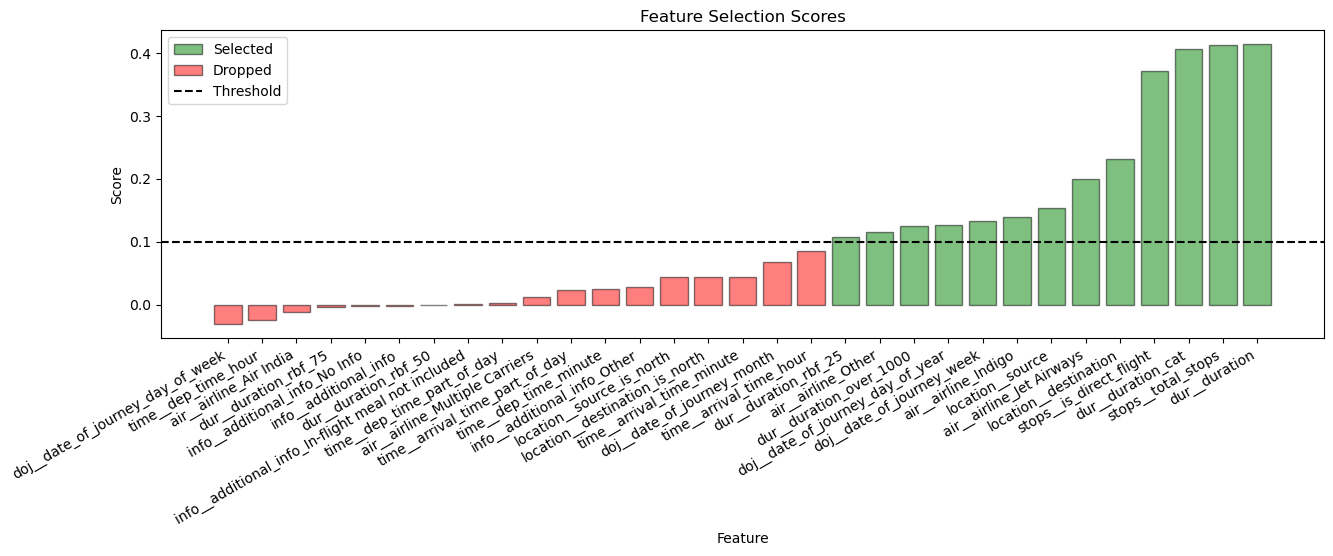

In [60]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- After doing feature engineering on the dataset the number of total columns went up to 31 
- The feature selection algorithm selected 13 features out of those 31